## Jurisdictional Complexity & Fire Response Analysis for Tribal Lands

**Fast-moving fires don't respect jurisdictional boundaries, but response systems do.**

This notebook analyzes the complex governance landscape on and around Tribal lands, mapping:
- Land ownership mosaics (Tribal/BIA/USFS/BLM/State/Private)
- Fire authority boundaries and overlaps
- Mutual aid agreement networks
- Jurisdictional fragmentation metrics

**Outputs:**
- Fragmentation indices quantifying governance complexity
- Visual correlation between jurisdictional complexity and fire risk
- Network maps of mutual aid relationships
- Recommendations for streamlining multi-jurisdictional response

### Imports

In [4]:
# Install required packages (uncomment if needed) or use tribal_fire.yaml to create the standard environment
# !pip install geopandas folium networkx pandas matplotlib seaborn scipy shapely rasterio contextily

In [5]:
# Imports
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import networkx as nx
from shapely.geometry import Point, Polygon, MultiPolygon, box
from shapely.ops import unary_union
from scipy.spatial import distance
from collections import defaultdict
import warnings
from datetime import datetime
import json
import os 

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries loaded successfully")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Libraries loaded successfully
Analysis date: 2026-02-16 20:18


### Load Reservation Boundaries

In [6]:
# Option 1: Load from official sources
# reservation_boundaries = gpd.read_file('path/to/reservation_boundaries.shp')
# Source: BIA AIAN Lands https://biamaps.doi.gov/

# Example: Create sample reservation data for demonstration
sample_reservations = {
    'reservation_name': [
        'Pine Ridge Reservation',
        'Fort Apache Reservation', 
        'Flathead Reservation',
        'Warm Springs Reservation'
    ],
    'state': ['SD', 'AZ', 'MT', 'OR'],
    'tribe': [
        'Oglala Sioux',
        'White Mountain Apache',
        'Confederated Salish and Kootenai',
        'Confederated Tribes of Warm Springs'
    ],
    'total_acres': [2800000, 1664872, 1244000, 644000],
    'lon': [-102.5, -110.0, -114.2, -121.3],
    'lat': [43.3, 33.8, 47.8, 44.8]
}

# Create sample geometries
reservations = gpd.GeoDataFrame(
    sample_reservations,
    geometry=[Point(lon, lat).buffer(0.5) for lon, lat in 
              zip(sample_reservations['lon'], sample_reservations['lat'])],
    crs='EPSG:4326'
)

print(f"Loaded {len(reservations)} reservations")
print("\nReservation summary:")
display(reservations[['reservation_name', 'state', 'tribe', 'total_acres']].head())

Loaded 4 reservations

Reservation summary:


,reservation_name,state,tribe,total_acres
0,Pine Ridge Reservation,SD,Oglala Sioux,2800000
1,Fort Apache Reservation,AZ,White Mountain Apache,1664872
2,Flathead Reservation,MT,Confederated Salish and Kootenai,1244000
3,Warm Springs Reservation,OR,Confederated Tribes of Warm Springs,644000


### Load Land Ownership Data

In [7]:
# Real data sources:
# - BLM Surface Management Agency (SMA): https://gbp-blm-egis.hub.arcgis.com/
# - USFS Proclaimed Forest boundaries
# - BIA Trust Land parcels
# - County assessor data for private lands

# For demonstration, create synthetic ownership parcels
def create_ownership_parcels(reservation_geom, reservation_name):
    """
    Create synthetic land ownership parcels within and around a reservation.
    In practice, load from actual ownership datasets.
    """
    bounds = reservation_geom.bounds
    parcels = []
    
    # Create grid of parcels
    grid_size = 0.1  # degrees
    ownership_types = ['Tribal', 'BIA Trust', 'USFS', 'BLM', 'State', 'Private']
    
    x_coords = np.arange(bounds[0], bounds[2], grid_size)
    y_coords = np.arange(bounds[1], bounds[3], grid_size)
    
    parcel_id = 0
    for x in x_coords:
        for y in y_coords:
            parcel_geom = box(x, y, x + grid_size, y + grid_size)
            
            # Check if parcel intersects reservation
            if parcel_geom.intersects(reservation_geom):
                # Higher probability of Tribal/BIA ownership inside reservation
                weights = [0.4, 0.3, 0.1, 0.05, 0.05, 0.1]
            else:
                # Outside reservation - more likely federal/private
                weights = [0.05, 0.05, 0.3, 0.2, 0.1, 0.3]
            
            owner = np.random.choice(ownership_types, p=weights)
            
            parcels.append({
                'parcel_id': f"{reservation_name[:3].upper()}_{parcel_id:04d}",
                'owner_type': owner,
                'reservation': reservation_name,
                'geometry': parcel_geom
            })
            parcel_id += 1
    
    return gpd.GeoDataFrame(parcels, crs='EPSG:4326')

# Generate ownership parcels for each reservation
all_parcels = []
for idx, res in reservations.iterrows():
    print(f"Generating ownership parcels for {res['reservation_name']}...")
    parcels = create_ownership_parcels(res.geometry, res['reservation_name'])
    all_parcels.append(parcels)

ownership_parcels = pd.concat(all_parcels, ignore_index=True)

print(f"\nCreated {len(ownership_parcels)} ownership parcels")
print("\nOwnership distribution:")
print(ownership_parcels['owner_type'].value_counts())

Generating ownership parcels for Pine Ridge Reservation...
Generating ownership parcels for Fort Apache Reservation...
Generating ownership parcels for Flathead Reservation...
Generating ownership parcels for Warm Springs Reservation...

Created 400 ownership parcels

Ownership distribution:
owner_type
Tribal       157
BIA Trust    104
Private       49
USFS          36
BLM           28
State         26
Name: count, dtype: int64


### Load Fire Authority Boundaries

In [8]:
# Fire authority jurisdictions typically correspond to:
# - BIA Fire Management Units
# - USFS Ranger Districts
# - BLM Fire Districts
# - State forestry protection areas
# - County/local fire districts
# - Tribal fire departments

def create_fire_authorities(reservations, ownership_parcels):
    """
    Create fire authority jurisdictions.
    In practice, load from official sources.
    """
    authorities = []
    
    for idx, res in reservations.iterrows():
        # Tribal Fire Department (reservation boundary)
        authorities.append({
            'authority_name': f"{res['tribe']} Fire Dept",
            'authority_type': 'Tribal',
            'reservation': res['reservation_name'],
            'has_mutual_aid': True,
            'staffing': np.random.randint(5, 25),
            'geometry': res.geometry
        })
        
        # BIA Fire Management (often overlaps with tribal)
        authorities.append({
            'authority_name': f"BIA {res['state']} Fire Management",
            'authority_type': 'BIA',
            'reservation': res['reservation_name'],
            'has_mutual_aid': True,
            'staffing': np.random.randint(10, 30),
            'geometry': res.geometry.buffer(0.2)  # Slightly larger
        })
        
        # USFS District (adjacent/overlapping)
        if np.random.random() > 0.3:  # 70% have USFS nearby
            authorities.append({
                'authority_name': f"USFS {res['reservation_name'].split()[0]} District",
                'authority_type': 'USFS',
                'reservation': res['reservation_name'],
                'has_mutual_aid': np.random.random() > 0.2,
                'staffing': np.random.randint(15, 40),
                'geometry': res.geometry.buffer(0.3)
            })
        
        # State Forestry
        authorities.append({
            'authority_name': f"{res['state']} State Forestry District",
            'authority_type': 'State',
            'reservation': res['reservation_name'],
            'has_mutual_aid': np.random.random() > 0.3,
            'staffing': np.random.randint(8, 20),
            'geometry': res.geometry.buffer(0.25)
        })
    
    return gpd.GeoDataFrame(authorities, crs='EPSG:4326')

fire_authorities = create_fire_authorities(reservations, ownership_parcels)

print(f"Created {len(fire_authorities)} fire authority jurisdictions")
print("\nAuthority type distribution:")
print(fire_authorities['authority_type'].value_counts())
print(f"\nAuthorities with mutual aid: {fire_authorities['has_mutual_aid'].sum()}")

Created 15 fire authority jurisdictions

Authority type distribution:
authority_type
Tribal    4
BIA       4
State     4
USFS      3
Name: count, dtype: int64

Authorities with mutual aid: 13


### Load Fire Risk Data

In [9]:
# Real data sources:
# - LANDFIRE Wildfire Hazard Potential (WHP)
# - USFS Wildfire Risk to Communities
# - State hazard assessments

# For demonstration, assign fire risk scores
def assign_fire_risk(reservations):
    """
    Assign fire risk scores (1-10 scale).
    In practice, extract from raster datasets like LANDFIRE WHP.
    """
    risk_data = reservations.copy()
    
    # Synthetic risk scores based on region (higher in west)
    risk_scores = []
    for idx, res in risk_data.iterrows():
        # Western states generally higher fire risk
        if res['state'] in ['AZ', 'MT', 'OR', 'CA', 'NV', 'WA', 'ID']:
            base_risk = np.random.uniform(6, 10)
        else:
            base_risk = np.random.uniform(3, 7)
        
        risk_scores.append(base_risk)
    
    risk_data['fire_risk_score'] = risk_scores
    risk_data['risk_category'] = pd.cut(
        risk_data['fire_risk_score'],
        bins=[0, 4, 7, 10],
        labels=['Low', 'Moderate', 'High']
    )
    
    return risk_data

reservations_with_risk = assign_fire_risk(reservations)

print("Fire risk assessment:")
display(reservations_with_risk[[
    'reservation_name', 'state', 'fire_risk_score', 'risk_category'
]])

Fire risk assessment:


,reservation_name,state,fire_risk_score,risk_category
0,Pine Ridge Reservation,SD,5.396390,Moderate
1,Fort Apache Reservation,AZ,9.752587,High
2,Flathead Reservation,MT,8.606572,High
3,Warm Springs Reservation,OR,9.869654,High


## Jurisdictional Fragmentation Analysis

### Calculate Fragmentation Metrics

In [10]:
def calculate_fragmentation_index(reservation_geom, ownership_parcels_gdf):
    """
    Calculate multiple fragmentation metrics for a reservation.
    
    Metrics:
    - Number of ownership types
    - Number of distinct parcels
    - Shannon Diversity Index (ownership heterogeneity)
    - Edge density (perimeter of parcels / area)
    - Largest patch index (% in single largest ownership)
    - Checkerboard index (ownership changes per unit distance)
    """
    # Get parcels within reservation
    intersecting = ownership_parcels_gdf[
        ownership_parcels_gdf.intersects(reservation_geom)
    ].copy()
    
    if len(intersecting) == 0:
        return {
            'num_ownership_types': 0,
            'num_parcels': 0,
            'shannon_diversity': 0,
            'edge_density': 0,
            'largest_patch_pct': 0,
            'fragmentation_index': 0
        }
    
    # Number of ownership types
    num_types = intersecting['owner_type'].nunique()
    
    # Number of distinct parcels
    num_parcels = len(intersecting)
    
    # Metric 3: Shannon Diversity Index
    ownership_counts = intersecting['owner_type'].value_counts()
    proportions = ownership_counts / ownership_counts.sum()
    shannon_diversity = -sum(proportions * np.log(proportions))
    
    # Edge density (total perimeter / total area)
    total_perimeter = sum([geom.length for geom in intersecting.geometry])
    total_area = reservation_geom.area
    edge_density = total_perimeter / total_area if total_area > 0 else 0
    
    # Largest patch index
    largest_ownership_count = ownership_counts.max()
    largest_patch_pct = (largest_ownership_count / num_parcels) * 100
    
    # Composite fragmentation index (normalized 0-100)
    # Higher = more fragmented
    norm_types = min(num_types / 6, 1) * 25  # Max 6 types
    norm_parcels = min(num_parcels / 100, 1) * 25  # Normalize by 100 parcels
    norm_shannon = min(shannon_diversity / 1.8, 1) * 25  # Max Shannon ~1.8
    norm_edge = min(edge_density / 50, 1) * 25  # Normalize edge density
    
    fragmentation_index = norm_types + norm_parcels + norm_shannon + norm_edge
    
    return {
        'num_ownership_types': num_types,
        'num_parcels': num_parcels,
        'shannon_diversity': shannon_diversity,
        'edge_density': edge_density,
        'largest_patch_pct': largest_patch_pct,
        'fragmentation_index': fragmentation_index
    }

# Calculate fragmentation for each reservation
fragmentation_results = []

for idx, res in reservations_with_risk.iterrows():
    print(f"Analyzing fragmentation for {res['reservation_name']}...")
    
    res_parcels = ownership_parcels[
        ownership_parcels['reservation'] == res['reservation_name']
    ]
    
    metrics = calculate_fragmentation_index(res.geometry, res_parcels)
    
    fragmentation_results.append({
        'reservation_name': res['reservation_name'],
        'state': res['state'],
        'fire_risk_score': res['fire_risk_score'],
        'risk_category': res['risk_category'],
        **metrics
    })

fragmentation_df = pd.DataFrame(fragmentation_results)

print("\n" + "="*80)
print("JURISDICTIONAL FRAGMENTATION ANALYSIS")
print("="*80)
display(fragmentation_df.sort_values('fragmentation_index', ascending=False))

Analyzing fragmentation for Pine Ridge Reservation...
Analyzing fragmentation for Fort Apache Reservation...
Analyzing fragmentation for Flathead Reservation...
Analyzing fragmentation for Warm Springs Reservation...

JURISDICTIONAL FRAGMENTATION ANALYSIS


,reservation_name,state,fire_risk_score,risk_category,num_ownership_types,num_parcels,shannon_diversity,edge_density,largest_patch_pct,fragmentation_index
2,Flathead Reservation,MT,8.606572,High,6,88,1.500968,44.890108,46.590909,90.291838
1,Fort Apache Reservation,AZ,9.752587,High,6,88,1.471979,44.890108,40.909091,89.889211
0,Pine Ridge Reservation,SD,5.396390,Moderate,6,88,1.380256,44.890108,43.181818,88.615281
3,Warm Springs Reservation,OR,9.869654,High,6,88,1.316074,44.890108,45.454545,87.723859


### Analyze Authority Overlap

In [ ]:
def analyze_authority_overlap(reservation_geom, authorities_gdf, reservation_name):
    """
    Analyze how many fire authorities have jurisdiction over areas.
    """
    # Get authorities covering this reservation
    relevant_authorities = authorities_gdf[
        authorities_gdf['reservation'] == reservation_name
    ]
    
    # Count overlapping authorities
    num_authorities = len(relevant_authorities)
    
    # Check for mutual aid agreements
    num_with_mutual_aid = relevant_authorities['has_mutual_aid'].sum()
    
    # Calculate average overlap (# of authorities per point)
    # Sample points within reservation
    bounds = reservation_geom.bounds
    sample_points = [
        Point(np.random.uniform(bounds[0], bounds[2]),
              np.random.uniform(bounds[1], bounds[3]))
        for _ in range(50)
    ]
    sample_points = [p for p in sample_points if reservation_geom.contains(p)]
    
    overlap_counts = []
    for point in sample_points:
        count = sum([auth.geometry.contains(point) 
                    for _, auth in relevant_authorities.iterrows()])
        overlap_counts.append(count)
    
    avg_overlap = np.mean(overlap_counts) if overlap_counts else 0
    max_overlap = max(overlap_counts) if overlap_counts else 0
    
    # Authority diversity (types of agencies)
    authority_types = relevant_authorities['authority_type'].nunique()
    
    return {
        'num_authorities': num_authorities,
        'num_with_mutual_aid': num_with_mutual_aid,
        'authority_types': authority_types,
        'avg_overlap': avg_overlap,
        'max_overlap': max_overlap,
        'mutual_aid_pct': (num_with_mutual_aid / num_authorities * 100) if num_authorities > 0 else 0
    }

# Analyze authority overlap for each reservation
authority_analysis = []

for idx, res in reservations_with_risk.iterrows():
    overlap_metrics = analyze_authority_overlap(
        res.geometry,
        fire_authorities,
        res['reservation_name']
    )
    
    authority_analysis.append({
        'reservation_name': res['reservation_name'],
        **overlap_metrics
    })

authority_df = pd.DataFrame(authority_analysis)

print("\nFIRE AUTHORITY OVERLAP ANALYSIS")
print("="*80)
display(authority_df)


FIRE AUTHORITY OVERLAP ANALYSIS


,reservation_name,num_authorities,num_with_mutual_aid,authority_types,avg_overlap,max_overlap,mutual_aid_pct
0,Pine Ridge Reservation,4,3,4,4.0,4,75.000000
1,Fort Apache Reservation,3,2,3,3.0,3,66.666667
2,Flathead Reservation,4,4,4,4.0,4,100.000000
3,Warm Springs Reservation,4,4,4,4.0,4,100.000000


### Combine Metrics into Complexity Score

In [12]:
# Merge fragmentation and authority data
complexity_analysis = fragmentation_df.merge(
    authority_df,
    on='reservation_name'
)

# Calculate composite governance complexity score (0-100)
def calculate_complexity_score(row):
    """
    Composite score combining:
    - Land ownership fragmentation (40%)
    - Authority overlap/confusion (30%)
    - Lack of mutual aid (30%)
    """
    # Normalize fragmentation index (already 0-100)
    frag_component = row['fragmentation_index'] * 0.4
    
    # Authority overlap component (more authorities = more complex)
    authority_component = min(row['num_authorities'] / 5, 1) * 30
    
    # Mutual aid gap component (less mutual aid = more complex)
    mutual_aid_component = (100 - row['mutual_aid_pct']) * 0.3
    
    return frag_component + authority_component + mutual_aid_component

complexity_analysis['governance_complexity_score'] = complexity_analysis.apply(
    calculate_complexity_score, axis=1
)

# Categorize complexity
complexity_analysis['complexity_category'] = pd.cut(
    complexity_analysis['governance_complexity_score'],
    bins=[0, 40, 65, 100],
    labels=['Low', 'Moderate', 'High']
)

print("\n" + "="*80)
print("GOVERNANCE COMPLEXITY RANKINGS")
print("="*80)
print("\nReservations ranked by governance complexity (highest = most complex):")
display(complexity_analysis[[
    'reservation_name', 'state', 
    'fragmentation_index', 'num_authorities', 'mutual_aid_pct',
    'governance_complexity_score', 'complexity_category'
]].sort_values('governance_complexity_score', ascending=False))


GOVERNANCE COMPLEXITY RANKINGS

Reservations ranked by governance complexity (highest = most complex):


,reservation_name,state,fragmentation_index,num_authorities,mutual_aid_pct,governance_complexity_score,complexity_category
0,Pine Ridge Reservation,SD,88.615281,4,75.000000,66.946113,High
1,Fort Apache Reservation,AZ,89.889211,3,66.666667,63.955684,Moderate
2,Flathead Reservation,MT,90.291838,4,100.000000,60.116735,Moderate
3,Warm Springs Reservation,OR,87.723859,4,100.000000,59.089544,Moderate


## Complexity vs. Fire Risk Analysis

### Correlation Analysis

In [21]:
# Analyze correlation between complexity and risk
correlation = complexity_analysis[[
    'fire_risk_score', 'governance_complexity_score'
]].corr().iloc[0, 1]

print(f"Correlation between Fire Risk and Governance Complexity: {correlation:.3f}")
print("\nInterpretation:")
if abs(correlation) < 0.3:
    print("Weak correlation:complexity issues exist regardless of fire risk")
elif abs(correlation) < 0.7:
    print("Moderate correlation: some relationship between risk and complexity")
else:
    print("Strong correlation: high-risk areas tend to have more complex governance")

# Identify critical areas (high risk + high complexity)
critical_areas = complexity_analysis[
    (complexity_analysis['risk_category'] == 'High') &
    (complexity_analysis['complexity_category'] == 'High')
]

print(f"\nCRITICAL AREAS: {len(critical_areas)} reservations with both HIGH FIRE RISK and HIGH GOVERNANCE COMPLEXITY")
if len(critical_areas) > 0:
    display(critical_areas[[
        'reservation_name', 'fire_risk_score', 'governance_complexity_score'
    ]])

Correlation between Fire Risk and Governance Complexity: -0.747

Interpretation:
Strong correlation: high-risk areas tend to have more complex governance

CRITICAL AREAS: 0 reservations with both HIGH FIRE RISK and HIGH GOVERNANCE COMPLEXITY


### Quadrant Analysis

In [14]:
def assign_quadrant(row, risk_median, complexity_median):
    """
    Assign reservations to quadrants:
    - Q1: High Risk, High Complexity (CRITICAL)
    - Q2: Low Risk, High Complexity (Inefficient)
    - Q3: Low Risk, Low Complexity (Manageable)
    - Q4: High Risk, Low Complexity (Well-positioned)
    """
    if row['fire_risk_score'] >= risk_median:
        if row['governance_complexity_score'] >= complexity_median:
            return 'Q1: High Risk, High Complexity (CRITICAL)'
        else:
            return 'Q4: High Risk, Low Complexity (Well-positioned)'
    else:
        if row['governance_complexity_score'] >= complexity_median:
            return 'Q2: Low Risk, High Complexity (Inefficient)'
        else:
            return 'Q3: Low Risk, Low Complexity (Manageable)'

risk_median = complexity_analysis['fire_risk_score'].median()
complexity_median = complexity_analysis['governance_complexity_score'].median()

complexity_analysis['quadrant'] = complexity_analysis.apply(
    lambda row: assign_quadrant(row, risk_median, complexity_median),
    axis=1
)

print("\nQUADRANT DISTRIBUTION")
print("="*80)
print(complexity_analysis['quadrant'].value_counts())

# Show each quadrant
for quadrant in sorted(complexity_analysis['quadrant'].unique()):
    print(f"\n{quadrant}:")
    display(complexity_analysis[
        complexity_analysis['quadrant'] == quadrant
    ][['reservation_name', 'fire_risk_score', 'governance_complexity_score']])


QUADRANT DISTRIBUTION
quadrant
Q2: Low Risk, High Complexity (Inefficient)        1
Q1: High Risk, High Complexity (CRITICAL)          1
Q3: Low Risk, Low Complexity (Manageable)          1
Q4: High Risk, Low Complexity (Well-positioned)    1
Name: count, dtype: int64

Q1: High Risk, High Complexity (CRITICAL):


,reservation_name,fire_risk_score,governance_complexity_score
1,Fort Apache Reservation,9.752587,63.955684



Q2: Low Risk, High Complexity (Inefficient):


,reservation_name,fire_risk_score,governance_complexity_score
0,Pine Ridge Reservation,5.39639,66.946113



Q3: Low Risk, Low Complexity (Manageable):


,reservation_name,fire_risk_score,governance_complexity_score
2,Flathead Reservation,8.606572,60.116735



Q4: High Risk, Low Complexity (Well-positioned):


,reservation_name,fire_risk_score,governance_complexity_score
3,Warm Springs Reservation,9.869654,59.089544


## Network Analysis

### Build Network Graph

In [15]:
def build_mutual_aid_network(fire_authorities, reservations):
    """
    Build network graph of mutual aid relationships.
    """
    G = nx.Graph()
    
    # Add nodes for each authority
    for idx, auth in fire_authorities.iterrows():
        G.add_node(
            auth['authority_name'],
            type=auth['authority_type'],
            reservation=auth['reservation'],
            has_mutual_aid=auth['has_mutual_aid'],
            staffing=auth['staffing']
        )
    
    # Add edges for mutual aid agreements
    # Authorities are connected if:
    # 1. Both have mutual_aid = True
    # 2. They operate in same or adjacent reservations
    
    for i, auth1 in fire_authorities.iterrows():
        if not auth1['has_mutual_aid']:
            continue
            
        for j, auth2 in fire_authorities.iterrows():
            if i >= j or not auth2['has_mutual_aid']:
                continue
            
            # Check if jurisdictions overlap or are adjacent
            if auth1.geometry.intersects(auth2.geometry):
                G.add_edge(
                    auth1['authority_name'],
                    auth2['authority_name'],
                    weight=1
                )
    
    return G

mutual_aid_network = build_mutual_aid_network(fire_authorities, reservations)

print(f"Mutual Aid Network Statistics:")
print(f"  Nodes (Authorities): {mutual_aid_network.number_of_nodes()}")
print(f"  Edges (Agreements): {mutual_aid_network.number_of_edges()}")
print(f"  Network Density: {nx.density(mutual_aid_network):.3f}")

# Identify isolated authorities (no mutual aid connections)
isolated = list(nx.isolates(mutual_aid_network))
print(f"  Isolated Authorities: {len(isolated)}")
if isolated:
    print(f"    {', '.join(isolated[:5])}{'...' if len(isolated) > 5 else ''}")

Mutual Aid Network Statistics:
  Nodes (Authorities): 15
  Edges (Agreements): 16
  Network Density: 0.152
  Isolated Authorities: 2
    USFS Pine District, AZ State Forestry District


### Network Metrics by Reservation

In [16]:
def calculate_network_metrics(reservation_name, network, authorities_df):
    """
    Calculate mutual aid network metrics for a reservation.
    """
    # Get authorities for this reservation
    res_authorities = authorities_df[
        authorities_df['reservation'] == reservation_name
    ]['authority_name'].tolist()
    
    # Subgraph for this reservation
    subgraph = network.subgraph(res_authorities)
    
    # Calculate metrics
    num_nodes = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()
    
    if num_nodes > 0:
        density = nx.density(subgraph)
        avg_degree = sum(dict(subgraph.degree()).values()) / num_nodes
        
        # Check connectivity
        is_connected = nx.is_connected(subgraph) if num_nodes > 1 else True
        num_components = nx.number_connected_components(subgraph)
    else:
        density = 0
        avg_degree = 0
        is_connected = False
        num_components = 0
    
    return {
        'network_nodes': num_nodes,
        'network_edges': num_edges,
        'network_density': density,
        'avg_connections': avg_degree,
        'is_connected': is_connected,
        'num_components': num_components
    }

# Calculate network metrics for each reservation
network_metrics = []

for res_name in reservations['reservation_name']:
    metrics = calculate_network_metrics(
        res_name,
        mutual_aid_network,
        fire_authorities
    )
    network_metrics.append({
        'reservation_name': res_name,
        **metrics
    })

network_df = pd.DataFrame(network_metrics)

print("\nMUTUAL AID NETWORK METRICS BY RESERVATION")
print("="*80)
display(network_df)


MUTUAL AID NETWORK METRICS BY RESERVATION


,reservation_name,network_nodes,network_edges,network_density,avg_connections,is_connected,num_components
0,Pine Ridge Reservation,4,3,0.500000,1.500000,False,2
1,Fort Apache Reservation,3,1,0.333333,0.666667,False,2
2,Flathead Reservation,4,6,1.000000,3.000000,True,1
3,Warm Springs Reservation,4,6,1.000000,3.000000,True,1


## Visualizations

### Complexity vs. Risk Scatter Plot

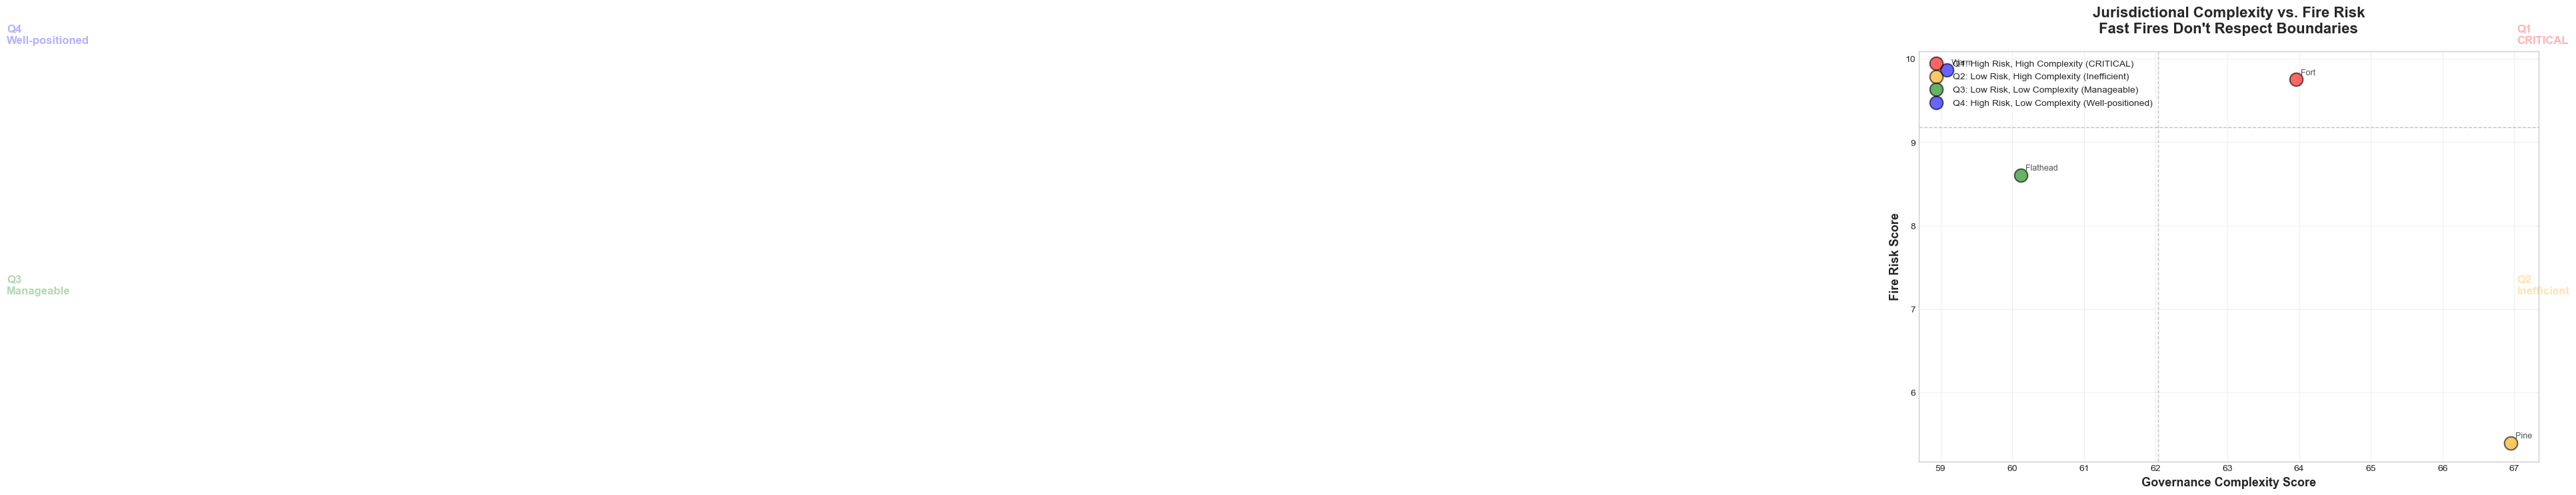


Scatter plot saved to: complexity_vs_risk.png


In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

# Create scatter plot with quadrants
quadrant_colors = {
    'Q1: High Risk, High Complexity (CRITICAL)': 'red',
    'Q2: Low Risk, High Complexity (Inefficient)': 'orange',
    'Q3: Low Risk, Low Complexity (Manageable)': 'green',
    'Q4: High Risk, Low Complexity (Well-positioned)': 'blue'
}

for quadrant, color in quadrant_colors.items():
    data = complexity_analysis[complexity_analysis['quadrant'] == quadrant]
    ax.scatter(
        data['governance_complexity_score'],
        data['fire_risk_score'],
        c=color,
        s=200,
        alpha=0.6,
        edgecolors='black',
        linewidth=1.5,
        label=quadrant
    )
    
    # Add labels for each point
    for idx, row in data.iterrows():
        ax.annotate(
            row['reservation_name'].split()[0],  # First word only
            (row['governance_complexity_score'], row['fire_risk_score']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            alpha=0.8
        )

# Add quadrant dividing lines
ax.axvline(complexity_median, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(risk_median, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add quadrant labels
ax.text(complexity_median + 5, risk_median + 1, 'Q1\nCRITICAL', 
        fontsize=12, fontweight='bold', alpha=0.3, color='red')
ax.text(complexity_median - 30, risk_median + 1, 'Q4\nWell-positioned', 
        fontsize=12, fontweight='bold', alpha=0.3, color='blue')
ax.text(complexity_median + 5, risk_median - 2, 'Q2\nInefficient', 
        fontsize=12, fontweight='bold', alpha=0.3, color='orange')
ax.text(complexity_median - 30, risk_median - 2, 'Q3\nManageable', 
        fontsize=12, fontweight='bold', alpha=0.3, color='green')

ax.set_xlabel('Governance Complexity Score', fontsize=13, fontweight='bold')
ax.set_ylabel('Fire Risk Score', fontsize=13, fontweight='bold')
ax.set_title('Jurisdictional Complexity vs. Fire Risk\nFast Fires Don\'t Respect Boundaries',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../output/complexity_vs_risk.png",
            dpi=300,
            bbox_inches='tight')
plt.show()

print("\nScatter plot saved to: complexity_vs_risk.png")

### Fragmentation Metrics Dashboard

In [18]:
# Check path and output folder
path = r"C:\Miniconda\Tribal_fire_science\output"

print("Exists:", os.path.exists(path))
print("Writable:", os.access(path, os.W_OK))
print("Current working directory:", os.getcwd())

Exists: True
Writable: True
Current working directory: c:\Miniconda\Tribal_fire_science\notebooks


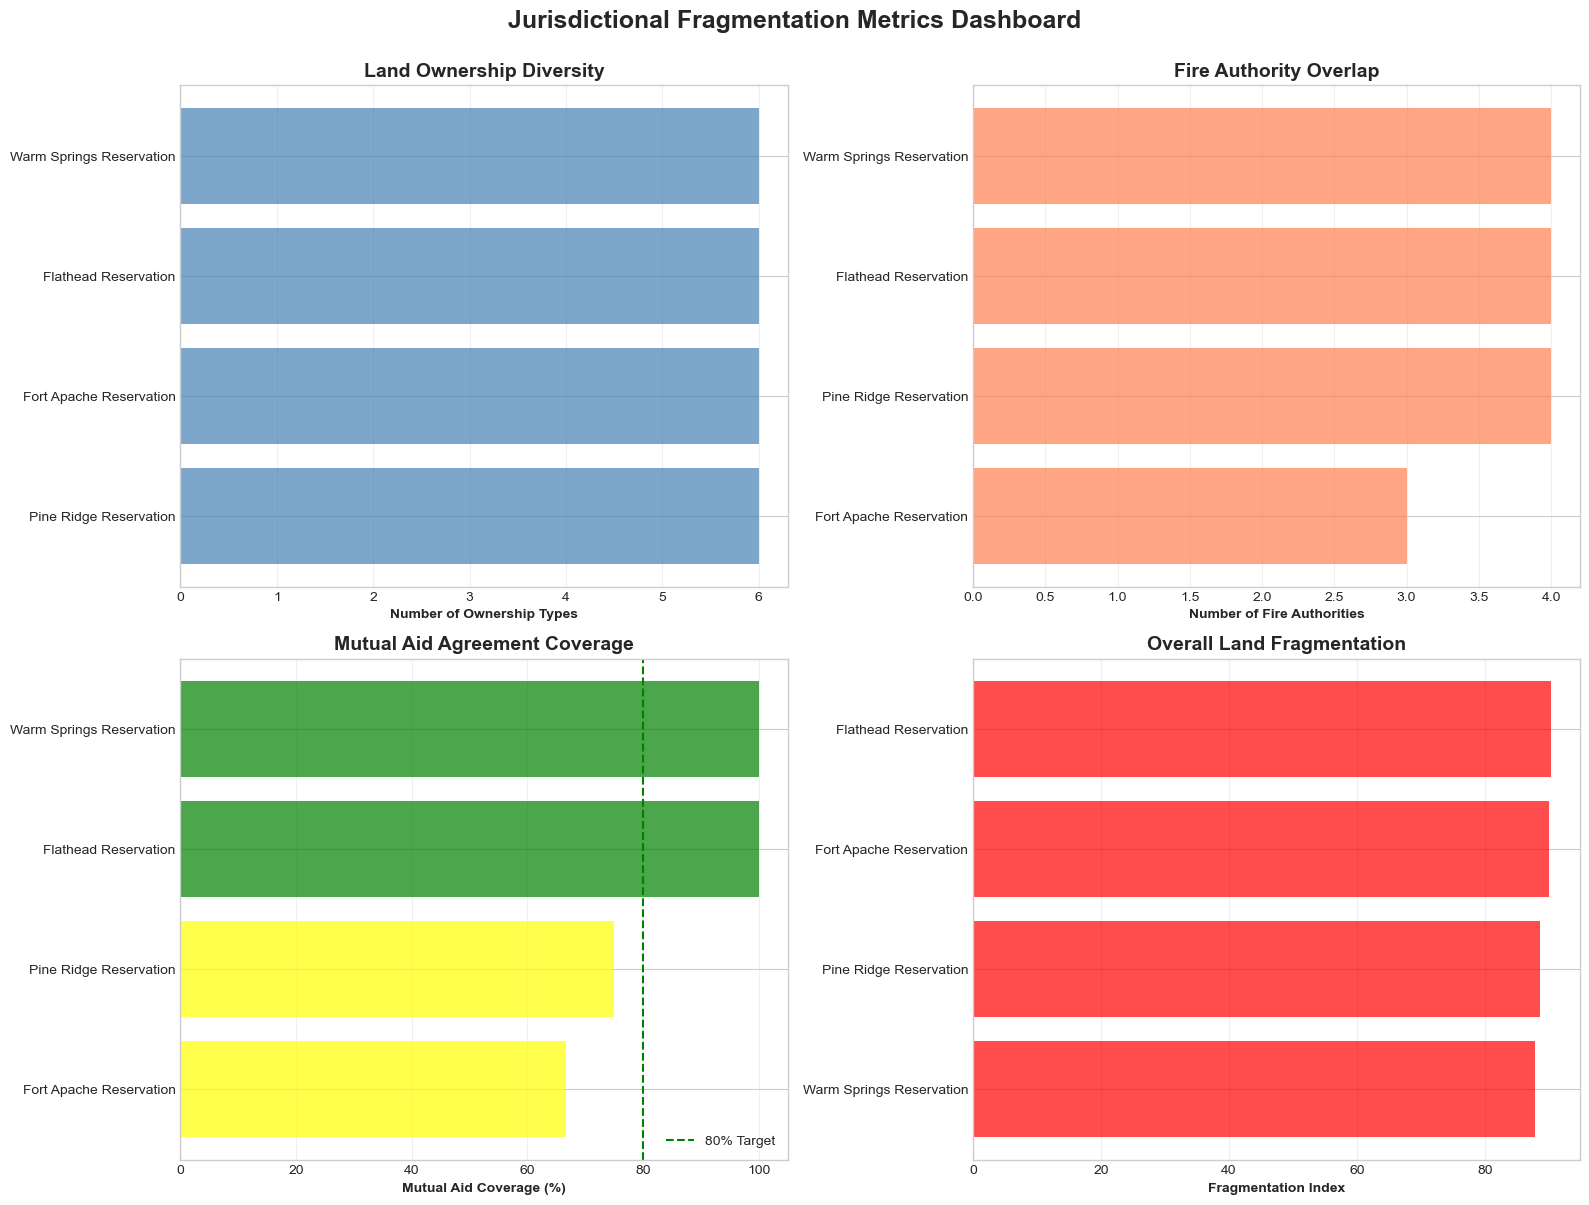


Dashboard saved to: output\fragmentation_dashboard.png


In [24]:
# Define output directory FIRST
output_dir = 'output' 
os.makedirs(output_dir, exist_ok=True)

# Create dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ownership Types
sorted_data = complexity_analysis.sort_values('num_ownership_types', ascending=True)
axes[0, 0].barh(sorted_data['reservation_name'], sorted_data['num_ownership_types'],
                color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Number of Ownership Types', fontweight='bold')
axes[0, 0].set_title('Land Ownership Diversity', fontweight='bold', fontsize=14)
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Number of Fire Authorities
sorted_data = complexity_analysis.sort_values('num_authorities', ascending=True)
axes[0, 1].barh(sorted_data['reservation_name'], sorted_data['num_authorities'],
                color='coral', alpha=0.7)
axes[0, 1].set_xlabel('Number of Fire Authorities', fontweight='bold')
axes[0, 1].set_title('Fire Authority Overlap', fontweight='bold', fontsize=14)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Mutual Aid Coverage
sorted_data = complexity_analysis.sort_values('mutual_aid_pct', ascending=True)
colors = ['red' if x < 50 else 'yellow' if x < 80 else 'green' 
          for x in sorted_data['mutual_aid_pct']]
axes[1, 0].barh(sorted_data['reservation_name'], sorted_data['mutual_aid_pct'],
                color=colors, alpha=0.7)
axes[1, 0].set_xlabel('Mutual Aid Coverage (%)', fontweight='bold')
axes[1, 0].set_title('Mutual Aid Agreement Coverage', fontweight='bold', fontsize=14)
axes[1, 0].axvline(80, color='green', linestyle='--', label='80% Target')
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].legend()

# Fragmentation Index
sorted_data = complexity_analysis.sort_values('fragmentation_index', ascending=True)
colors = ['green' if x < 40 else 'yellow' if x < 65 else 'red' 
          for x in sorted_data['fragmentation_index']]
axes[1, 1].barh(sorted_data['reservation_name'], sorted_data['fragmentation_index'],
                color=colors, alpha=0.7)
axes[1, 1].set_xlabel('Fragmentation Index', fontweight='bold')
axes[1, 1].set_title('Overall Land Fragmentation', fontweight='bold', fontsize=14)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.suptitle('Jurisdictional Fragmentation Metrics Dashboard',
             fontsize=18, fontweight='bold', y=1.00)

plt.tight_layout()

# Save figure - FIXED
save_path = os.path.join(output_dir, "fragmentation_dashboard.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"\nDashboard saved to: {save_path}")


### Mutual Aid Network Visualization

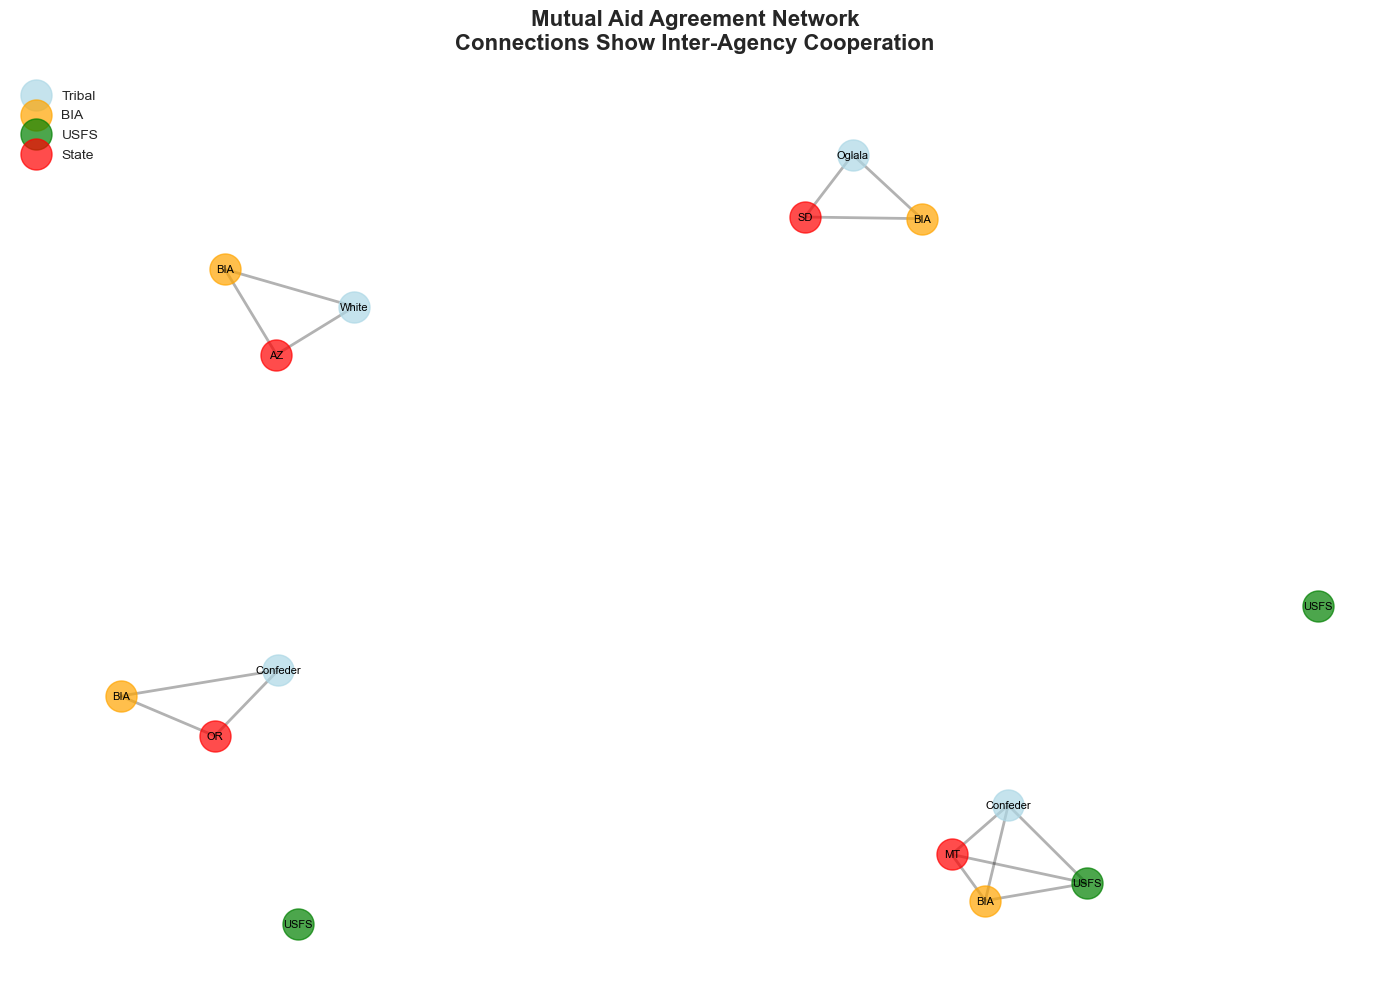


✓ Network diagram saved to: ../output/mutual_aid_network.png


In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))

# Create layout
pos = nx.spring_layout(mutual_aid_network, k=0.5, iterations=50, seed=42)

# Color nodes by authority type
authority_type_colors = {
    'Tribal': 'lightblue',
    'BIA': 'orange',
    'USFS': 'green',
    'State': 'red',
    'BLM': 'purple'
}

for auth_type, color in authority_type_colors.items():
    nodes = [node for node in mutual_aid_network.nodes() 
             if mutual_aid_network.nodes[node]['type'] == auth_type]
    if nodes:
        nx.draw_networkx_nodes(
            mutual_aid_network, pos,
            nodelist=nodes,
            node_color=color,
            node_size=500,
            alpha=0.7,
            label=auth_type,
            ax=ax
        )

# Draw edges
nx.draw_networkx_edges(
    mutual_aid_network, pos,
    alpha=0.3,
    width=2,
    ax=ax
)

# Draw labels (abbreviated)
labels = {node: node.split()[0][:8] for node in mutual_aid_network.nodes()}
nx.draw_networkx_labels(
    mutual_aid_network, pos,
    labels,
    font_size=8,
    ax=ax
)

ax.set_title('Mutual Aid Agreement Network\nConnections Show Inter-Agency Cooperation',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', framealpha=0.9)
ax.axis('off')

plt.tight_layout()
plt.savefig("../output/mutual_aid_network.png",
            dpi=300,
            bbox_inches='tight')
plt.show()

print("\nNetwork diagram saved to: ../output/mutual_aid_network.png")

### Interactive Map with Ownership Mosaic

In [ ]:
def create_jurisdiction_map(reservations, ownership_parcels, fire_authorities, complexity_df):
    """
    Create interactive map showing jurisdictional complexity.
    """
    # Calculate center
    center_lat = reservations.geometry.centroid.y.mean()
    center_lon = reservations.geometry.centroid.x.mean()
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=5,
        tiles='OpenStreetMap'
    )
    
    # Add ownership parcels layer
    ownership_colors = {
        'Tribal': '#4169E1',      # Royal Blue
        'BIA Trust': '#00CED1',   # Dark Turquoise
        'USFS': '#228B22',        # Forest Green
        'BLM': '#DAA520',         # Goldenrod
        'State': '#DC143C',       # Crimson
        'Private': '#808080'      # Gray
    }
    
    ownership_layer = folium.FeatureGroup(name='Land Ownership', show=True)
    
    # Sample parcels to avoid overwhelming the map
    sample_parcels = ownership_parcels.sample(min(500, len(ownership_parcels)))
    
    for idx, parcel in sample_parcels.iterrows():
        folium.GeoJson(
            parcel.geometry,
            style_function=lambda x, color=ownership_colors.get(parcel['owner_type'], 'gray'): {
                'fillColor': color,
                'color': 'black',
                'weight': 0.5,
                'fillOpacity': 0.4
            },
            tooltip=f"{parcel['owner_type']}"
        ).add_to(ownership_layer)
    
    ownership_layer.add_to(m)
    
    # Add reservation boundaries with complexity info
    res_layer = folium.FeatureGroup(name='Reservations', show=True)
    
    for idx, res in reservations.iterrows():
        # Get complexity data
        res_complexity = complexity_df[
            complexity_df['reservation_name'] == res['reservation_name']
        ].iloc[0] if len(complexity_df) > 0 else None
        
        # Color by complexity
        if res_complexity is not None:
            complexity_score = res_complexity['governance_complexity_score']
            if complexity_score < 40:
                color = 'green'
            elif complexity_score < 65:
                color = 'orange'
            else:
                color = 'red'
        else:
            color = 'gray'
        
        popup_html = f"""
        <div style="font-family: Arial; font-size: 12px; min-width: 250px;">
            <h4 style="margin-bottom: 10px;">{res['reservation_name']}</h4>
            <b>Tribe:</b> {res['tribe']}<br>
            <b>Size:</b> {res['total_acres']:,} acres<br>
        """
        
        if res_complexity is not None:
            popup_html += f"""
            <hr style="margin: 10px 0;">
            <b>Fire Risk:</b> {res_complexity['fire_risk_score']:.1f}/10<br>
            <b>Complexity Score:</b> {res_complexity['governance_complexity_score']:.1f}/100<br>
            <b>Ownership Types:</b> {res_complexity['num_ownership_types']}<br>
            <b>Fire Authorities:</b> {res_complexity['num_authorities']}<br>
            <b>Mutual Aid Coverage:</b> {res_complexity['mutual_aid_pct']:.0f}%<br>
            <b>Category:</b> <span style="color: {color}; font-weight: bold;">
            {res_complexity['complexity_category']}</span>
            """
        
        popup_html += "</div>"
        
        folium.GeoJson(
            res.geometry,
            style_function=lambda x, c=color: {
                'fillColor': c,
                'color': 'black',
                'weight': 3,
                'fillOpacity': 0.1
            },
            popup=folium.Popup(popup_html, max_width=350),
            tooltip=res['reservation_name']
        ).add_to(res_layer)
    
    res_layer.add_to(m)
    
    # Add fire authority boundaries
    auth_layer = folium.FeatureGroup(name='Fire Authorities', show=False)
    
    authority_colors_map = {
        'Tribal': 'blue',
        'BIA': 'cyan',
        'USFS': 'green',
        'State': 'red',
        'BLM': 'purple'
    }
    
    for idx, auth in fire_authorities.iterrows():
        color = authority_colors_map.get(auth['authority_type'], 'gray')
        
        popup_html = f"""
        <div style="font-family: Arial; font-size: 12px;">
            <h4>{auth['authority_name']}</h4>
            <b>Type:</b> {auth['authority_type']}<br>
            <b>Staffing:</b> {auth['staffing']} personnel<br>
            <b>Mutual Aid:</b> {'Yes' if auth['has_mutual_aid'] else 'No'}<br>
        </div>
        """
        
        folium.GeoJson(
            auth.geometry,
            style_function=lambda x, c=color: {
                'fillColor': c,
                'color': c,
                'weight': 2,
                'fillOpacity': 0.05,
                'dashArray': '5, 5'
            },
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(auth_layer)
    
    auth_layer.add_to(m)
    
    # Add layer control
    folium.LayerControl(collapsed=False).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 280px; height: auto;
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <h4 style="margin-top:0;">Legend</h4>
    <p style="margin: 5px 0;"><b>Land Ownership:</b></p>
    <p style="margin: 2px 0;"><span style="color:#4169E1">■</span> Tribal</p>
    <p style="margin: 2px 0;"><span style="color:#00CED1">■</span> BIA Trust</p>
    <p style="margin: 2px 0;"><span style="color:#228B22">■</span> USFS</p>
    <p style="margin: 2px 0;"><span style="color:#DAA520">■</span> BLM</p>
    <p style="margin: 2px 0;"><span style="color:#DC143C">■</span> State</p>
    <p style="margin: 2px 0;"><span style="color:#808080">■</span> Private</p>
    <p style="margin: 10px 0 5px 0;"><b>Complexity Level:</b></p>
    <p style="margin: 2px 0;"><span style="color:green">■</span> Low</p>
    <p style="margin: 2px 0;"><span style="color:orange">■</span> Moderate</p>
    <p style="margin: 2px 0;"><span style="color:red">■</span> High</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Create interactive map
interactive_map = create_jurisdiction_map(
    reservations_with_risk,
    ownership_parcels,
    fire_authorities,
    complexity_analysis
)

# Save map
map_path = "../output/interactive_map.html"
interactive_map.save(map_path)
print(f"\nInteractive map saved to: {map_path}")


# Display in notebook
interactive_map


✓ Interactive map saved to: ../output/interactive_map.html


## Export Results and Recommendations

### Export Spatial Data

In [ ]:
# Create output directory
output_dir = 'C:\Miniconda\Tribal_fire_science\output'
os.makedirs(output_dir, exist_ok=True)

# Export complexity analysis with geometries
complexity_export = reservations_with_risk.merge(
    complexity_analysis,
    on='reservation_name'
)[['reservation_name', 'state_x', 'tribe', 'fire_risk_score_x',
   'governance_complexity_score', 'complexity_category', 
   'quadrant', 'geometry']]

complexity_export.columns = ['reservation_name', 'state', 'tribe', 
                             'fire_risk_score',
                             'governance_complexity_score', 
                             'complexity_category', 
                             'quadrant', 'geometry']


complexity_export.to_file(
    f'{output_dir}/complexity_analysis.geojson',
    driver='GeoJSON'
)
print(f"✓ Exported: {output_dir}/complexity_analysis.geojson")

# Export ownership parcels (sample)
ownership_parcels.sample(min(1000, len(ownership_parcels))).to_file(
    f'{output_dir}/ownership_parcels_sample.geojson',
    driver='GeoJSON'
)
print(f"Exported: {output_dir}/ownership_parcels_sample.geojson")

# Export fire authorities
fire_authorities.to_file(
    f'{output_dir}/fire_authorities.geojson',
    driver='GeoJSON'
)
print(f"Exported: {output_dir}/fire_authorities.geojson")

✓ Exported: C:\Miniconda\Tribal_fire_science\output/complexity_analysis.geojson
✓ Exported: C:\Miniconda\Tribal_fire_science\output/ownership_parcels_sample.geojson
✓ Exported: C:\Miniconda\Tribal_fire_science\output/fire_authorities.geojson


### Export Network Data

In [26]:
# Export network as edge list
edge_list = []
for edge in mutual_aid_network.edges():
    edge_list.append({
        'source': edge[0],
        'target': edge[1],
        'source_type': mutual_aid_network.nodes[edge[0]]['type'],
        'target_type': mutual_aid_network.nodes[edge[1]]['type']
    })

edge_df = pd.DataFrame(edge_list)
edge_df.to_csv(f'{output_dir}/mutual_aid_network.csv', index=False)
print(f"Exported: {output_dir}/mutual_aid_network.csv")

# Export network metrics
network_df.to_csv(f'{output_dir}/network_metrics.csv', index=False)
print(f"Exported: {output_dir}/network_metrics.csv")

Exported: C:\Miniconda\Tribal_fire_science\output/mutual_aid_network.csv
Exported: C:\Miniconda\Tribal_fire_science\output/network_metrics.csv


### Generate Summary Report

In [27]:
# Create comprehensive summary report
report = f"""
{'='*80}
JURISDICTIONAL COMPLEXITY & FIRE RESPONSE ANALYSIS
{'='*80}
Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}

EXECUTIVE SUMMARY
{'='*80}

INSIGHTS: Fast-moving fires do not respect jurisdictional boundaries,
but emergency response systems do. This analysis reveals critical governance
barriers that impede rapid, coordinated fire response on tribal lands.

Reservations Analyzed: {len(reservations)}
Land Parcels Mapped: {len(ownership_parcels)}
Fire Authorities Identified: {len(fire_authorities)}
Mutual Aid Agreements: {fire_authorities['has_mutual_aid'].sum()}

CRITICAL FINDINGS
{'='*80}

High-Risk, High-Complexity Areas: {len(critical_areas)}
""" 

if len(critical_areas) > 0:
    report += "\nCRITICAL PRIORITY RESERVATIONS:\n"
    for idx, area in critical_areas.iterrows():
        report += f"  • {area['reservation_name']}\n"
        report += f"    Fire Risk: {area['fire_risk_score']:.1f}/10\n"
        report += f"    Complexity: {area['governance_complexity_score']:.1f}/100\n"
        report += f"    Ownership Types: {area['num_ownership_types']}\n"
        report += f"    Fire Authorities: {area['num_authorities']}\n"
        report += f"    Mutual Aid: {area['mutual_aid_pct']:.0f}%\n\n"

report += f"""
FRAGMENTATION STATISTICS
{'='*80}

Average Ownership Types per Reservation: {complexity_analysis['num_ownership_types'].mean():.1f}
Average Land Parcels per Reservation: {complexity_analysis['num_parcels'].mean():.0f}
Average Fragmentation Index: {complexity_analysis['fragmentation_index'].mean():.1f}/100

Most Fragmented: {complexity_analysis.nlargest(1, 'fragmentation_index')['reservation_name'].iloc[0]}
  Fragmentation Index: {complexity_analysis['fragmentation_index'].max():.1f}
  Ownership Types: {complexity_analysis.nlargest(1, 'fragmentation_index')['num_ownership_types'].iloc[0]}

Least Fragmented: {complexity_analysis.nsmallest(1, 'fragmentation_index')['reservation_name'].iloc[0]}
  Fragmentation Index: {complexity_analysis['fragmentation_index'].min():.1f}
  Ownership Types: {complexity_analysis.nsmallest(1, 'fragmentation_index')['num_ownership_types'].iloc[0]}

FIRE AUTHORITY ANALYSIS
{'='*80}

Average Fire Authorities per Reservation: {complexity_analysis['num_authorities'].mean():.1f}
Average Mutual Aid Coverage: {complexity_analysis['mutual_aid_pct'].mean():.1f}%

Reservations with <50% Mutual Aid: {len(complexity_analysis[complexity_analysis['mutual_aid_pct'] < 50])}
Reservations with ≥3 Overlapping Authorities: {len(complexity_analysis[complexity_analysis['num_authorities'] >= 3])}

MUTUAL AID NETWORK
{'='*80}

Total Authorities: {mutual_aid_network.number_of_nodes()}
Active Mutual Aid Connections: {mutual_aid_network.number_of_edges()}
Network Density: {nx.density(mutual_aid_network):.3f}
Isolated Authorities (No Agreements): {len(list(nx.isolates(mutual_aid_network)))}

RISK CORRELATION
{'='*80}

Correlation (Fire Risk vs. Complexity): {correlation:.3f}
"""

if abs(correlation) < 0.3:
    report += "\nInterpretation: Governance complexity exists independently of fire risk.\n"
    report += "This suggests systemic jurisdictional issues affecting all reservations.\n"
else:
    report += "\nInterpretation: Higher fire risk correlates with governance complexity.\n"
    report += "This compounds challenges in high-risk areas.\n"

report += f"""

QUADRANT DISTRIBUTION
{'='*80}
"""

for quadrant in sorted(complexity_analysis['quadrant'].unique()):
    count = len(complexity_analysis[complexity_analysis['quadrant'] == quadrant])
    report += f"\n{quadrant}: {count}\n"
    areas = complexity_analysis[complexity_analysis['quadrant'] == quadrant]['reservation_name'].tolist()
    report += f"  {', '.join(areas)}\n"

report += f"""

{'='*80}
END OF REPORT
{'='*80}
"""

# Save report
report_path = f'{output_dir}/jurisdictional_complexity_report.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(f"\nSummary report saved to: {report_path}")
print("\n" + report)


Summary report saved to: C:\Miniconda\Tribal_fire_science\output/jurisdictional_complexity_report.txt


JURISDICTIONAL COMPLEXITY & FIRE RESPONSE ANALYSIS
Report Generated: 2026-02-16 20:45

EXECUTIVE SUMMARY

INSIGHTS: Fast-moving fires do not respect jurisdictional boundaries,
but emergency response systems do. This analysis reveals critical governance
barriers that impede rapid, coordinated fire response on tribal lands.

Reservations Analyzed: 4
Land Parcels Mapped: 400
Fire Authorities Identified: 15
Mutual Aid Agreements: 13

CRITICAL FINDINGS

High-Risk, High-Complexity Areas: 0

FRAGMENTATION STATISTICS

Average Ownership Types per Reservation: 6.0
Average Land Parcels per Reservation: 88
Average Fragmentation Index: 89.1/100

Most Fragmented: Flathead Reservation
  Fragmentation Index: 90.3
  Ownership Types: 6

Least Fragmented: Warm Springs Reservation
  Fragmentation Index: 87.7
  Ownership Types: 6

FIRE AUTHORITY ANALYSIS

Average Fire Authorities per Reservation: 3.8
Av

### Generate Recommendations

In [28]:
recommendations = []

# Critical areas recommendations
if len(critical_areas) > 0:
    recommendations.append({
        'priority': 'CRITICAL',
        'category': 'High Risk + High Complexity',
        'issue': f"{len(critical_areas)} reservations face both high fire risk and severe jurisdictional complexity",
        'recommendation': 'Establish unified incident command protocols and pre-positioned mutual aid agreements',
        'affected_areas': critical_areas['reservation_name'].tolist(),
        'implementation': [
            'Develop inter-agency MOUs before fire season',
            'Conduct joint training exercises',
            'Create unified communication protocols',
            'Establish clear authority delegation procedures'
        ]
    })

# Low mutual aid coverage
low_mutual_aid = complexity_analysis[complexity_analysis['mutual_aid_pct'] < 50]
if len(low_mutual_aid) > 0:
    recommendations.append({
        'priority': 'HIGH',
        'category': 'Mutual Aid Gaps',
        'issue': f"{len(low_mutual_aid)} reservations have <50% mutual aid coverage",
        'recommendation': 'Expand mutual aid agreement network to ensure comprehensive coverage',
        'affected_areas': low_mutual_aid['reservation_name'].tolist(),
        'implementation': [
            'Facilitate agreement negotiations between agencies',
            'Address liability and cost-sharing concerns',
            'Standardize agreement templates',
            'Create regional mutual aid compacts'
        ]
    })

# High ownership fragmentation
highly_fragmented = complexity_analysis[complexity_analysis['fragmentation_index'] > 65]
if len(highly_fragmented) > 0:
    recommendations.append({
        'priority': 'HIGH',
        'category': 'Land Fragmentation',
        'issue': f"{len(highly_fragmented)} reservations have severe land ownership fragmentation",
        'recommendation': 'Develop landscape-scale coordination mechanisms that transcend ownership boundaries',
        'affected_areas': highly_fragmented['reservation_name'].tolist(),
        'implementation': [
            'Create coordinating councils with all landowners',
            'Develop landscape fire management plans',
            'Establish cross-boundary prescribed fire programs',
            'Implement unified dispatch systems'
        ]
    })

# Authority overlap issues
high_overlap = complexity_analysis[complexity_analysis['num_authorities'] >= 4]
if len(high_overlap) > 0:
    recommendations.append({
        'priority': 'MEDIUM',
        'category': 'Authority Clarification',
        'issue': f"{len(high_overlap)} reservations have 4+ overlapping fire authorities",
        'recommendation': 'Clarify authority hierarchies and establish clear incident command structures',
        'affected_areas': high_overlap['reservation_name'].tolist(),
        'implementation': [
            'Document jurisdiction boundaries and authorities',
            'Create decision matrices for incident command',
            'Conduct tabletop exercises',
            'Establish standing interagency teams'
        ]
    })

# Isolated authorities
isolated = list(nx.isolates(mutual_aid_network))
if len(isolated) > 0:
    recommendations.append({
        'priority': 'MEDIUM',
        'category': 'Network Integration',
        'issue': f"{len(isolated)} fire authorities operate without mutual aid connections",
        'recommendation': 'Integrate isolated authorities into regional mutual aid networks',
        'affected_areas': isolated[:5],  # List first 5
        'implementation': [
            'Identify barriers to agreement participation',
            'Provide technical assistance for agreement development',
            'Address resource and capacity constraints',
            'Build trust through joint projects'
        ]
    })

# Format recommendations
rec_report = "\n" + "="*80 + "\n"
rec_report += "RECOMMENDATIONS FOR REDUCING JURISDICTIONAL BARRIERS\n"
rec_report += "="*80 + "\n\n"

for i, rec in enumerate(recommendations, 1):
    rec_report += f"{i}. [{rec['priority']}] {rec['category']}\n"
    rec_report += f"   Issue: {rec['issue']}\n"
    rec_report += f"   Recommendation: {rec['recommendation']}\n"
    rec_report += f"   Affected Areas ({len(rec['affected_areas'])}): "
    rec_report += f"{', '.join(rec['affected_areas'][:3])}"
    if len(rec['affected_areas']) > 3:
        rec_report += f" and {len(rec['affected_areas'])-3} more"
    rec_report += "\n   Implementation Steps:\n"
    for step in rec['implementation']:
        rec_report += f"     • {step}\n"
    rec_report += "\n"

# Save recommendations
rec_path = f'{output_dir}/recommendations.txt'
with open(rec_path, 'w') as f:
    f.write(rec_report)

# Also save as structured data
rec_df = pd.DataFrame([{
    'priority': r['priority'],
    'category': r['category'],
    'issue': r['issue'],
    'recommendation': r['recommendation'],
    'num_affected': len(r['affected_areas'])
} for r in recommendations])

rec_df.to_csv(f'{output_dir}/recommendations.csv', index=False)

print(f"\nRecommendations saved to: {rec_path}")
print(rec_report)


Recommendations saved to: C:\Miniconda\Tribal_fire_science\output/recommendations.txt

RECOMMENDATIONS FOR REDUCING JURISDICTIONAL BARRIERS

1. [HIGH] Land Fragmentation
   Issue: 4 reservations have severe land ownership fragmentation
   Recommendation: Develop landscape-scale coordination mechanisms that transcend ownership boundaries
   Affected Areas (4): Pine Ridge Reservation, Fort Apache Reservation, Flathead Reservation and 1 more
   Implementation Steps:
     • Create coordinating councils with all landowners
     • Develop landscape fire management plans
     • Establish cross-boundary prescribed fire programs
     • Implement unified dispatch systems

2. [MEDIUM] Authority Clarification
   Issue: 3 reservations have 4+ overlapping fire authorities
   Recommendation: Clarify authority hierarchies and establish clear incident command structures
   Affected Areas (3): Pine Ridge Reservation, Flathead Reservation, Warm Springs Reservation
   Implementation Steps:
     • Documen

## Data Sources

### Real-World Data Sources:

1. **Tribal Boundaries**
   - BIA American Indian/Alaska Native (AIAN) Lands: https://biamaps.doi.gov/
   - Census TIGER/Line AIAN Areas

2. **Land Ownership**
   - BLM Surface Management Agency (SMA) Dataset
   - USFS Proclaimed Forest Boundaries
   - BIA Trust Land Parcel Data
   - State land inventories
   - County assessor databases (private lands)

3. **Fire Authorities**
   - BIA Division of Fire Management jurisdictions
   - USFS Fire & Aviation Management unit boundaries
   - State forestry protection districts
   - County/rural fire protection boundaries
   - Tribal fire department service areas

4. **Mutual Aid Agreements**
   - State forestry departments
   - Regional compacts (e.g., Northwest Compact)
   - Tribal-federal agreements
   - County emergency management

5. **Fire Risk Data**
   - LANDFIRE Wildfire Hazard Potential (WHP)
   - USFS Wildfire Risk to Communities
   - State hazard assessments

### TODO:

1. **Temporal Analysis**: Track how jurisdictional complexity changes over time
2. **Response Time Modeling**: Integrate with road networks and station locations
3. **Cost Analysis**: Quantify inefficiencies from jurisdictional fragmentation
4. **Case Studies**: Analyze actual fire incidents crossing boundaries
5. **Policy Scenarios**: Model impact of different coordination mechanisms
6. **Cultural Factors**: Incorporate tribal sovereignty and governance preferences
7. **Resource Sharing**: Map equipment, personnel, and capability sharing

### Insights:

This analysis reveals that jurisdictional complexity is not just an administrative issue, it creates tangible barriers to protecting lives, property, and cultural resources from wildfire. By quantifying and visualizing these barriers, we can make the case for streamlined coordination and mutual aid systems that match the speed and scale of modern wildfires.